In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import os
import tensorflow as tf
from keras import models
from keras import layers
import pathlib
import PIL
import seaborn as sns
import time
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from sklearn.model_selection import train_test_split, cross_val_score
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
import shutil
import random
import glob
import sys
import itertools
import warnings
import statistics

In [2]:
# Define Result Saving Initial Function
dfcols = ['model_name', 'Train Accuracy', 'Test Accuracy', 'CV1', 'CV2', 'CV3', 'CV4', 'CV5', 'CV_Std', 'CV_avg']
model_summary = pd.DataFrame(columns=dfcols)


def save_result(model_name, Train_Accuracy, Test_Accuracy, cv1, cv2, cv3, cv4, cv5):
            global model_summary
            cv_std = statistics.stdev([cv1, cv2, cv3, cv4, cv5])
            cv_avg = (cv1 + cv2 + cv3 + cv4 + cv5) / 5
            row = [(model_name, Train_Accuracy, Test_Accuracy, cv1, cv2, cv3, cv4, cv5, cv_std, cv_avg)]
            res = pd.DataFrame(columns = dfcols, data = row)
            yeep = [model_summary, res]
            model_summary = pd.concat(yeep)
            model_summary = model_summary.sort_values('CV_avg', ascending = False)
            model_summary = model_summary.drop_duplicates()
            return model_summary.round(3)

In [3]:
train_norm_size = len(os.listdir('re-split_data/train/normal'))
train_pneum_size = len(os.listdir('re-split_data/train/pneumonia'))
test_norm_size = len(os.listdir('re-split_data/test/normal'))
test_pneum_size = len(os.listdir('re-split_data/test/pneumonia'))
valid_norm_size = len(os.listdir('re-split_data/validation/normal'))
valid_pneum_size = len(os.listdir('re-split_data/validation/pneumonia'))


train_size = train_norm_size + train_pneum_size -1
test_size = test_norm_size + test_pneum_size -1
validation_size = valid_norm_size + valid_pneum_size

print(f' There are {train_size} images in the training set, {test_size} in the test set, and {validation_size} in the validation set')

print(f'train norm is {train_norm_size}')
print(f'train pneum is {train_pneum_size}')
print(f'test norm: {test_norm_size}')
print(f'test pneum: {test_pneum_size}')
print(f'valid norm: {valid_norm_size}')
print(f'valid pneum: {valid_pneum_size}')


 There are 3272 images in the training set, 1752 in the test set, and 816 in the validation set
train norm is 883
train pneum is 2390
test norm: 473
test pneum: 1280
valid norm: 220
valid pneum: 596


In [4]:
train_path = 're-split_data/train'
valid_path = 're-split_data/validation'
test_path = 're-split_data/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224),  batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224),  batch_size=32, shuffle=False)

Found 3272 images belonging to 2 classes.
Found 816 images belonging to 2 classes.
Found 1752 images belonging to 2 classes.


In [6]:
# create the data sets

train_images2, train_labels2 = next(train_batches)
test_images2, test_labels2 = next(test_batches)
valid_images2, valid_labels2 = next(valid_batches)

train_img2 = train_images2.reshape(train_images2.shape[0], -1)
test_img2 = test_images2.reshape(test_images2.shape[0], -1)
valid_img2 = valid_images2.reshape(valid_images2.shape[0], -1)

print(train_img2.shape)
print(test_img2.shape)
print(valid_img2.shape)




(32, 150528)
(32, 150528)
(32, 150528)


In [7]:
len(train_labels2)

32

In [8]:
train_y2 = np.reshape(train_labels2[:,0], (32,1))
test_y2 = np.reshape(test_labels2[:,0], (32,1))
valid_y2 = np.reshape(valid_labels2[:,0], (32,1))

print(train_y2.shape)
print(test_y2.shape)
print(valid_y2.shape)

(32, 1)
(32, 1)
(32, 1)


In [9]:
# get all the data in the directory split/test , and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/train',
        target_size=(64, 64), batch_size = train_size) 

test_generator =ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/test',
        target_size=(64, 64), batch_size = test_size, shuffle= False) 

valid_generator =ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/validation',
        target_size=(64, 64), batch_size = validation_size)

Found 3272 images belonging to 2 classes.
Found 1752 images belonging to 2 classes.
Found 816 images belonging to 2 classes.


In [11]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
valid_images, valid_labels = next(valid_generator)

In [12]:
def show_images(images):
    fig, axes = plt.subplots(1, 10, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

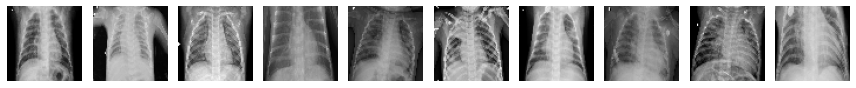

In [13]:
show_images(train_images)

In [14]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
valid_img = valid_images.reshape(valid_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(valid_img.shape)

(3272, 12288)
(1752, 12288)
(816, 12288)


In [15]:
train_y = np.reshape(train_labels[:,0], (train_size,1))
test_y = np.reshape(test_labels[:,0], (test_size,1))
valid_y = np.reshape(valid_labels[:,0], (validation_size,1))

print(train_y.shape)
print(test_y.shape)
print(valid_y.shape)

(3272, 1)
(1752, 1)
(816, 1)


In [16]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

vgg16_model.summary()

In [18]:
# create new model of type sequential, then iterate over each of layers in vgg model (save last),
#  add layers to sequential.
#model_VGG = Sequential()
#for layer in vgg16_model.layers[:-1]:
   # model_VGG.add(layer)

In [19]:
#for layer in model_VGG.layers:
   # layer.trainable = False

In [20]:
#model_VGG.add(Dense(units=2, activation='sigmoid'))

In [21]:
#model_VGG.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [22]:
#vgg_hist = model_VGG.fit(x=train_batches,
 #                       steps_per_epoch = len(train_batches),
 #                       validation_data=valid_batches,
  #                      validation_steps = len(valid_batches),
 #                       epochs=7)

In [23]:
#os.mkdir('models')

In [24]:
#model_VGG.save('models/VGG_model.h5')

In [25]:
# load model
from tensorflow.keras.models import load_model
new_model = load_model('models/VGG_model.h5')

In [26]:
model_VGG = new_model

In [27]:
#results_train = model_VGG.evaluate(train_images2, train_y2) # DOESNT WORK
#results_test = model_VGG.evaluate(test_images, test_y)   # Doesnt WORK

In [28]:
test_images, test_labels= next(test_batches)

In [29]:
predictions = model_VGG.predict(x=test_batches, steps=len(test_batches), verbose = 0)

In [30]:
y_pred = np.argmax(predictions, axis = 1)

In [31]:
y_true = test_batches.classes

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_true = y_true, y_pred = y_pred)
cm

array([[ 421,   52],
       [  40, 1239]], dtype=int64)

Confusion matrix, without normalization
[[ 421   52]
 [  40 1239]]


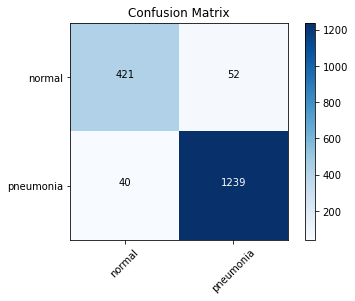

In [33]:
cm_plot_labels = ['normal','pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')